In [13]:
import pandas as pd
import numpy as np
import polars as pl

from typing import Any , Literal

from src.factor.calculator import StockFactorCalculator
from src.data import DATAVENDOR

__all__ = [
    'npro_core_ratio' , 'gp_margin_qtr' , 'gp_margin_ttm' , 'gp_margin_zscore' ,
    'gp_ta_qtr' , 'gp_ta_ttm' , 'gp_ta_zscore' ,
    'dedt_equ_ttm' , 'dedt_sales_ttm' , 'dedt_ta_ttm' ,
    'roe_qtr' , 'roe_ttm' , 'roe_zscore' ,
    'roa_qtr' , 'roa_ttm' , 'roa_zscore' ,
    'net_margin_qtr' , 'net_margin_ttm' , 'net_margin_zscore' ,
    'cfo_sales_qtr' , 'cfo_sales_ttm' , 'cfo_sales_zscore' ,
    'cfo_ta_qtr' , 'cfo_ta_ttm' , 'cfo_ta_zscore' ,
    'oper_margin_qtr' , 'oper_margin_ttm' , 'oper_margin_zscore' ,
    'expense_sales_qtr' , 'expense_sales_ttm' , 'expense_sales_zscore' ,
    'roic_qtr' , 'roic_ttm' , 'roic_zscore' ,
    'ebit_tangible_ttm' , 
    'tax_equ_qtr' , 'tax_equ_ttm' , 'tax_equ_zscore'
]

def get_hist_zscore(expression : str , date : int):
    data = DATAVENDOR.get_fin_hist(expression , date , 12).iloc[:,0]
    grp = data.groupby('secid')
    return (grp.last() - grp.mean()) / grp.std()


def get_hist_zscore_polars(expression : str , date : int):
    data = DATAVENDOR.get_fin_hist(expression , date , 12).iloc[:,0]
    df = pl.from_pandas(data.rename('value').to_frame() , include_index=True)
    return df.group_by('secid', maintain_order=True).\
        agg((pl.col('value').last() - pl.col('value').mean()) / pl.col('value').std()).\
            to_pandas().set_index('secid').iloc[:,0]

class npro_core_ratio(StockFactorCalculator):
    init_date = 20110101
    category0 = 'fundamental'
    category1 = 'earning'
    description = '核心净利润占比'
    
    def calc_factor(self, date: int):
        npro = DATAVENDOR.get_fin_latest('npro@ttm' , date)
        gp = DATAVENDOR.get_fin_latest('gp@ttm' , date)
        subtracts = [DATAVENDOR.get_fin_latest(expr , date).reindex(gp.index).fillna(0) 
                    for expr in ['is@biz_tax_surchg@ttm' , 'is@sell_exp@ttm' , 'is@admin_exp@ttm' , 'is@fin_exp@ttm' , 'is@rd_exp@ttm']]
        core = gp - sum(subtracts)
        return core / npro

In [17]:
date = 20110822
core = DATAVENDOR.get_fin_latest('gp@ttm - is@biz_tax_surchg@ttm - is@sell_exp@ttm - is@admin_exp@ttm - is@fin_exp@ttm - is@rd_exp@ttm' , date)
core

secid
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
688391   NaN
688519   NaN
831039   NaN
833943   NaN
873827   NaN
Name: gross_margin - biz_tax_surchg - sell_exp - admin_exp - fin_exp - rd_exp, Length: 2464, dtype: float64

In [21]:
gp = DATAVENDOR.get_fin_latest('gp@ttm' , date)
subtracts = [DATAVENDOR.get_fin_latest(expr , date).reindex(gp.index).fillna(0) 
             for expr in ['is@biz_tax_surchg@ttm' , 'is@sell_exp@ttm' , 'is@admin_exp@ttm' , 'is@fin_exp@ttm' , 'is@rd_exp@ttm']]
core = gp - sum(subtracts)
core

secid
2         1.164366e+10
3        -2.084932e+07
4         2.265858e+07
5         2.500563e+07
6         4.887635e+08
              ...     
688391    4.401679e+07
688519    3.147664e+07
831039    5.018547e+07
833943    3.739079e+07
873827    8.376695e+07
Length: 2380, dtype: float64

In [20]:
biz_tax_surchg

secid
1         1.670796e+09
2         6.448857e+09
3         2.292940e+05
4         7.136923e+06
5         1.331276e+06
              ...     
688336    9.187831e+05
688391    1.257924e+05
688519    2.362068e+04
831039    4.610028e+06
833943    2.690881e+05
Name: biz_tax_surchg, Length: 2433, dtype: float64

In [19]:
gp

secid
2         2.310988e+10
3         4.821170e+06
4         5.519987e+07
5         5.891536e+07
6         1.112131e+09
              ...     
688391    6.684163e+07
688519    8.768137e+07
831039    8.518319e+07
833943    8.127192e+07
873827    8.376695e+07
Name: gross_margin, Length: 2380, dtype: float64

In [14]:
# inday_mkt_beta.Calc(20110822)
df = npro_core_ratio.Calc(20110822)

In [15]:
df

secid
1        NaN
2        NaN
4        NaN
6        NaN
7        NaN
          ..
600991   NaN
601258   NaN
601268   NaN
601299   NaN
601558   NaN
Name: npro_core_ratio, Length: 2247, dtype: float64

In [1]:
from src.api import FactorAPI
hier = FactorAPI.factor_hierarchy()
hier.factor_df()['file_name'].unique()


src.INSTANCE_RECORD can be accessed to check ['trainer', 'account']
Basic module imported!


array(['analyst\\adjustment', 'analyst\\coverage', 'analyst\\forecast',
       'analyst\\surprise', 'behavior\\behavior_anndt',
       'behavior\\behavior_ff3', 'behavior\\behavior_slice',
       'behavior\\correlation_beta', 'behavior\\correlation_vp',
       'behavior\\liquidity_cap', 'behavior\\liquidity_cv',
       'behavior\\liquidity_illiquid', 'behavior\\liquidity_turnover',
       'behavior\\momentum_classic', 'behavior\\momentum_mdr',
       'behavior\\momentum_phigh', 'behavior\\momentum_weivol',
       'behavior\\volatility_exret', 'behavior\\volatility_ret',
       'behavior\\volatility_skew', 'fundamental\\earning_classic',
       'fundamental\\earning_sue', 'fundamental\\earning_tsreg',
       'fundamental\\growth_acc', 'fundamental\\growth_classic',
       'fundamental\\growth_long', 'fundamental\\growth_rankdelta',
       'fundamental\\growth_trend', 'fundamental\\growth_yoyzscore',
       'fundamental\\quality', 'fundamental\\valuation_dynamic',
       'fundamental\\va

In [2]:
factor_values = hier.test_calc_all_factors(ignore_error = False , verbose = True) # file_name = ''fundamental\\valuation_augment'' , 

uppct_npro_3m calculated , valid_ratio is 44.47%
upnum_npro_3m calculated , valid_ratio is 44.47%
upnum_npro_6m calculated , valid_ratio is 46.97%
rec_npro_3m calculated , valid_ratio is 44.47%
rec_npro_6m calculated , valid_ratio is 46.95%
upnum_npro_12m calculated , valid_ratio is 53.50%
cov_inst_3m calculated , valid_ratio is 100.00%
uppct_npro_12m calculated , valid_ratio is 53.50%
rec_npro_12m calculated , valid_ratio is 53.48%
cov_inst_12m calculated , valid_ratio is 100.00%
cov_report_3m calculated , valid_ratio is 100.00%
uppct_npro_6m calculated , valid_ratio is 46.97%
cov_inst_6m calculated , valid_ratio is 100.00%
cov_report_6m calculated , valid_ratio is 100.00%
cov_report_12m calculated , valid_ratio is 100.00%
upnum_npro_6m_anndt calculated , valid_ratio is 42.38%
rec_npro_6m_anndt calculated , valid_ratio is 42.35%
cov_inst_12m_anndt calculated , valid_ratio is 100.00%
uppct_npro_6m_anndt calculated , valid_ratio is 42.38%
eps_est_pct3m calculated , valid_ratio is 56.52%

In [ ]:
factor_values = hier.test_calc_all_factors(category0 = 'analyst' , multi_thread = True) # file_name = 'moneyflow/holding' , 

src.INSTANCE_RECORD can be accessed to check ['trainer', 'account']
Basic module imported!
etop_augment at 20241213 calculated
etop_augment at 20241115 calculated
etop_augment at 20241101 calculated
etop_augment at 20241129 calculated


StockFactor(normalized=False,names=['etop_augment'],dates=20241101-20241213)

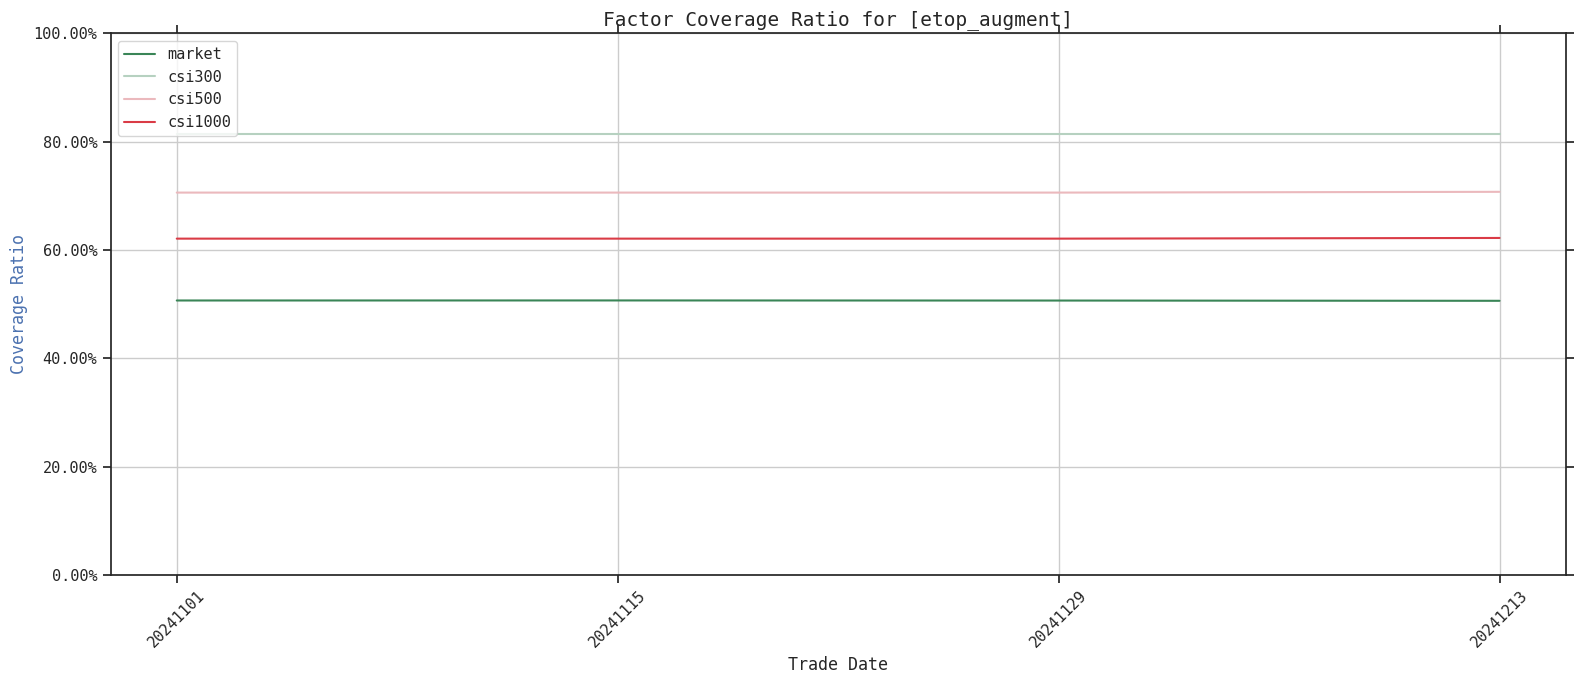

In [1]:
from src.api import FactorAPI
hier = FactorAPI.factor_hierarchy()
calc = hier.get_factor('etop_augment')
factor = calc.Factor(20241101 , multi_thread=True)
factor.analyze('Coverage')

In [7]:
hier.get_factor('ff_alpha_1m')().calc_factor(20241203)


secid
1         0.001472
2        -0.003134
4        -0.006647
6        -0.001304
7        -0.004757
            ...   
920088   -0.001742
920099    0.000018
920111    0.012260
920118    0.010361
920128   -0.002829
Name: ff_alpha_1m, Length: 5372, dtype: float64

In [2]:
from src.api import FactorAPI
hier = FactorAPI.factor_hierarchy()
hier.update_jobs(0 , 20241231 , True).jobs()


src.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']
Basic module imported!


,level,date,factor
79,level0,20241217,ampl_slicecp1m
100,level0,20241217,amt_cv12m
101,level0,20241217,amt_cv1m
102,level0,20241217,amt_cv2m
103,level0,20241217,amt_cv3m
...,...,...,...
386,level0,20241217,vol_high_std
430,level1,20241217,btop_augment
431,level1,20241217,cfev_augment
432,level1,20241217,etop_augment


In [18]:
hier.update()

Factor level1/fundamental/value/btop_augment at date 20241101 deploy successful
Factor level1/fundamental/value/cfev_augment at date 20241101 deploy successful
Factor level1/fundamental/value/etop_augment at date 20241101 deploy successful
Factor level1/fundamental/value/valuation_augment at date 20241101 deploy successful
Factor level1/fundamental/value/btop_augment at date 20241104 deploy successful
Factor level1/fundamental/value/cfev_augment at date 20241104 deploy successful
Factor level1/fundamental/value/etop_augment at date 20241104 deploy successful
Factor level1/fundamental/value/valuation_augment at date 20241104 deploy successful
Factor level1/fundamental/value/btop_augment at date 20241105 deploy successful
Factor level1/fundamental/value/cfev_augment at date 20241105 deploy successful
Factor level1/fundamental/value/etop_augment at date 20241105 deploy successful
Factor level1/fundamental/value/valuation_augment at date 20241105 deploy successful
Factor level1/fundamental

In [2]:
from src_factor_definition.level1.fundamental.valuation_augment import btop_augment
btop_augment.Calc(20240620)

secid
1              NaN
2              NaN
4              NaN
6              NaN
7        -0.539658
            ...   
873706         NaN
873726   -0.173380
873806         NaN
873833         NaN
920002         NaN
Name: btop_augment, Length: 5365, dtype: float64

In [1]:
from src_factor_definition.level1.fundamental.valuation_augment import btop_augment
factor = btop_augment.Factor(20240101)

src.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']
Basic module imported!
btop_augment at 20240419 calculated
btop_augment at 20240130 calculated
btop_augment at 20240320 calculated
btop_augment at 20240306 calculatedbtop_augment at 20240522 calculated

btop_augment at 20240116 calculated
btop_augment at 20240403 calculated
btop_augment at 20240102 calculated
btop_augment at 20240221 calculated
btop_augment at 20240508 calculated
btop_augment at 20240620 calculated
btop_augment at 20241104 calculated
btop_augment at 20241118 calculated
btop_augment at 20241202 calculated
btop_augment at 20241216 calculated
btop_augment at 20240605 calculated
btop_augment at 20240704 calculated
btop_augment at 20240815 calculated
btop_augment at 20240912 calculated
btop_augment at 20240829 calculated
btop_augment at 20240801 calculated
btop_augment at 20240718 calculated
btop_augment at 20241021 calculated
btop_augment at 20240930 calculated


In [6]:
self = factor

factors = self.factor_names
df = self.frame_with_cols(fut_ret = True)
ic = df.groupby(by=['date'], as_index=True).apply(lambda x:x[factors].corrwith(x['ret'], method='pearson'))


In [13]:
ic.mean() / ic.std() * (250 / 10) ** 0.5

btop_augment    0.467088
dtype: float64

In [3]:
from src.factor.analytic.factor_perf.calculator import Factor_IC_Curve
calc = Factor_IC_Curve()
calc.calc(factor)
calc.calc_rslt

date        ic    cum_ic     ma_10     ma_20
factor_name  benchmark                                                  
btop_augment market     20240102  0.159530  0.159530       NaN       NaN
             market     20240116  0.184942  0.344472       NaN       NaN
             market     20240130 -0.029805  0.314667       NaN       NaN
             market     20240221 -0.159847  0.154820       NaN       NaN
             market     20240306 -0.015496  0.139324       NaN       NaN
...                          ...       ...       ...       ...       ...
             csi1000    20241021  0.016872  0.441610  0.031856  0.022080
             csi1000    20241104  0.178215  0.619825  0.053347  0.017056
             csi1000    20241118 -0.051258  0.568567  0.022584 -0.001386
             csi1000    20241202       NaN       NaN       NaN       NaN
             csi1000    20241216       NaN       NaN       NaN       NaN

[96 rows x 5 columns]

{'btop_augment.market': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi300': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi500': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi1000': <Figure size 1600x700 with 2 Axes>}

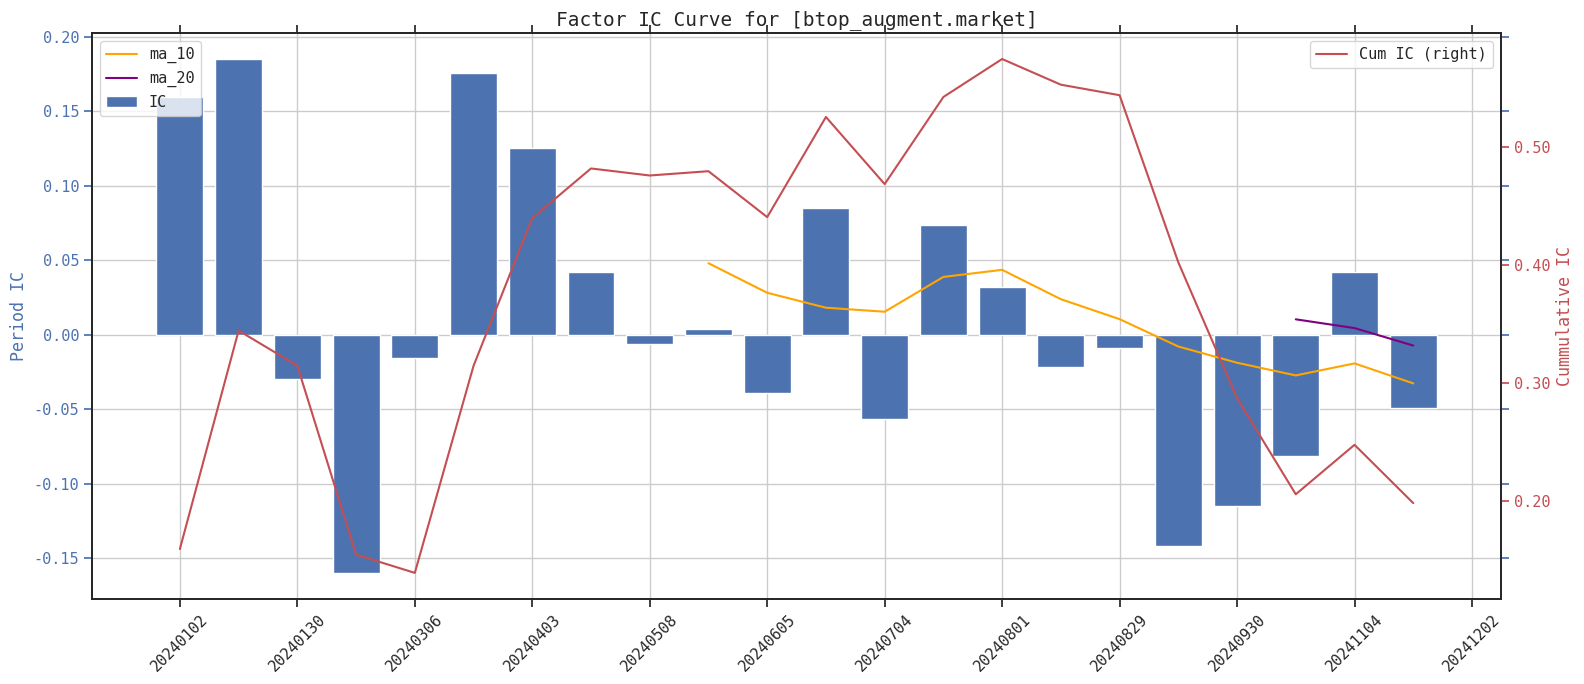

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from src.factor.util.plot import plot_table , get_twin_axes , set_xaxis , set_yaxis , PlotMultipleData , PlotFactorData , sns_lineplot , sns_barplot

def plot_factor_ic_curve(data : pd.DataFrame , show = False):
    group_plot = PlotMultipleData(data , group_key = ['factor_name' , 'benchmark'])
    for i , sub_data in enumerate(group_plot):     
        with PlotFactorData(sub_data , title = 'Factor IC Curve' , dropna = False , show=show and i==0) as (df , fig):
            df = df.set_index('date').sort_index()
            ax1 , ax2 = get_twin_axes(fig , 111)

            ax1.bar(df.index, df['ic'], color='b', label='IC')
            colors = ['orange','purple','olive','pink','cyan','grey','azure','yellow']
            for col in df.columns.tolist():
                if col.startswith('ma_'): ax1.plot(df.index, df[col], color=colors.pop(0) , label=col)  
            ax1.legend(loc='upper left')

            ax2.plot(df.index, df['cum_ic'], 'r-', label='Cum IC (right)')  
            ax2.legend(loc='upper right')  

            set_xaxis(ax1 , df.index)
            set_yaxis(ax1 , format='flt' , digits=2 , title = 'Period IC' , title_color='b' , tick_color='b')
            set_yaxis(ax2 , format='flt' , digits=2 , title = 'Cummulative IC' , title_color='r' , tick_color='r' , tick_pos=None)
            
    return group_plot.fig_dict

plot_factor_ic_curve(calc.calc_rslt , True)

StockFactor(normalized=True,names=['btop_augment'],dates=20240102-20241216)

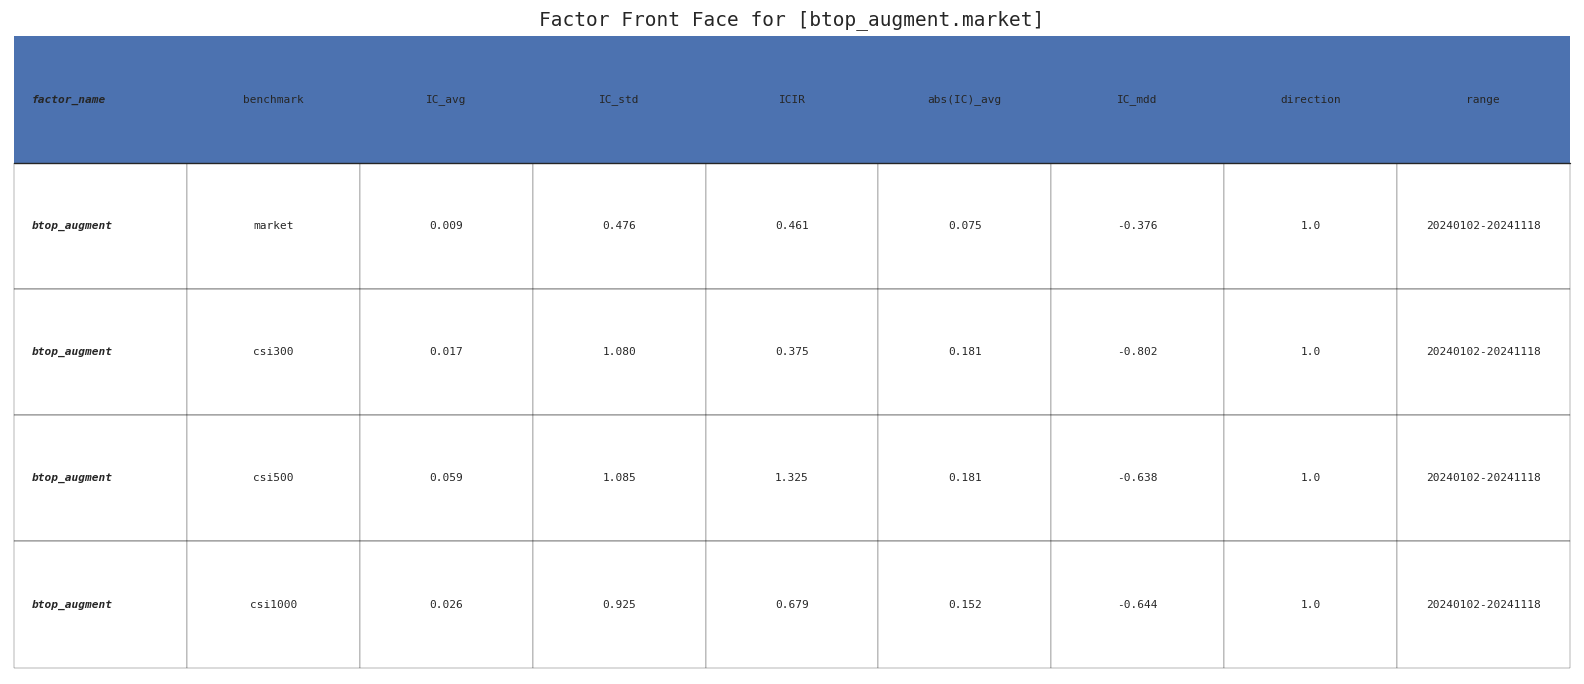

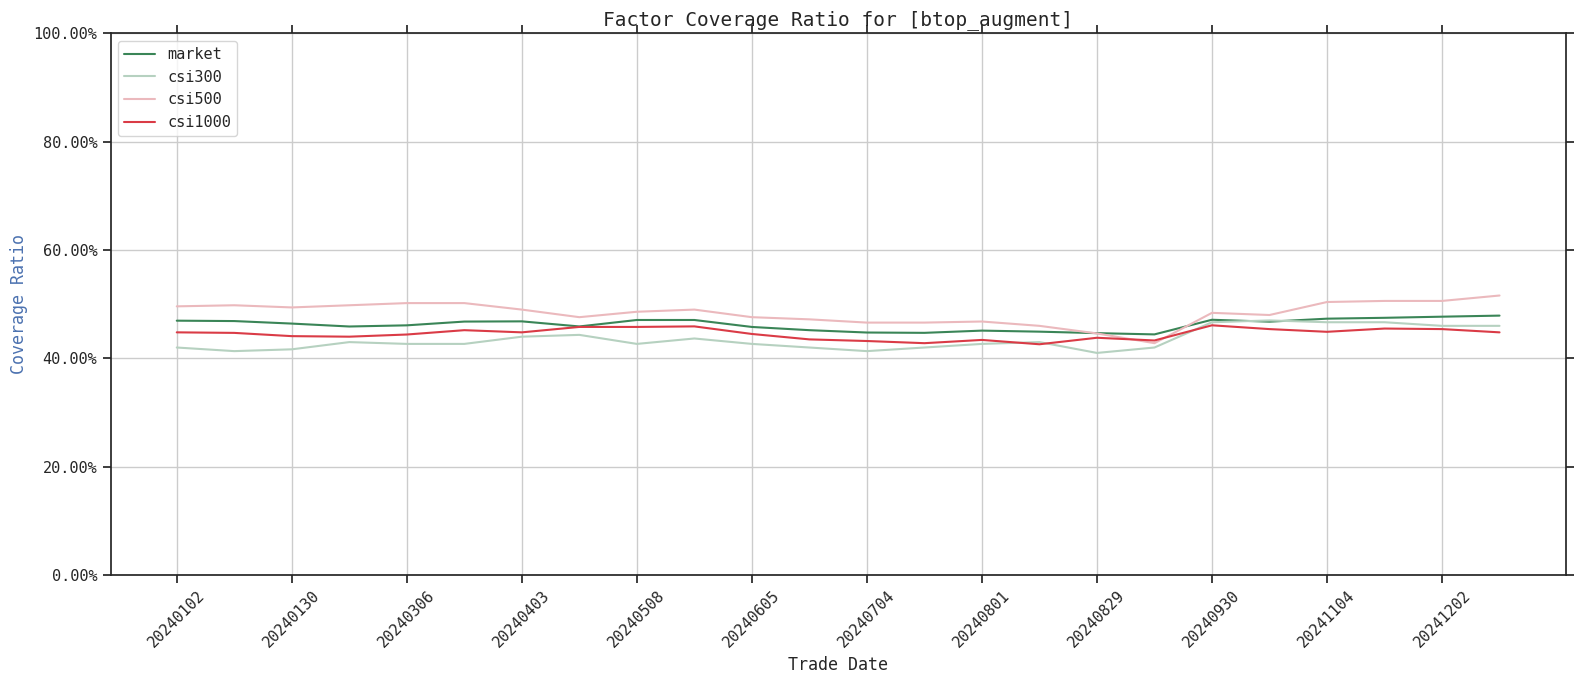

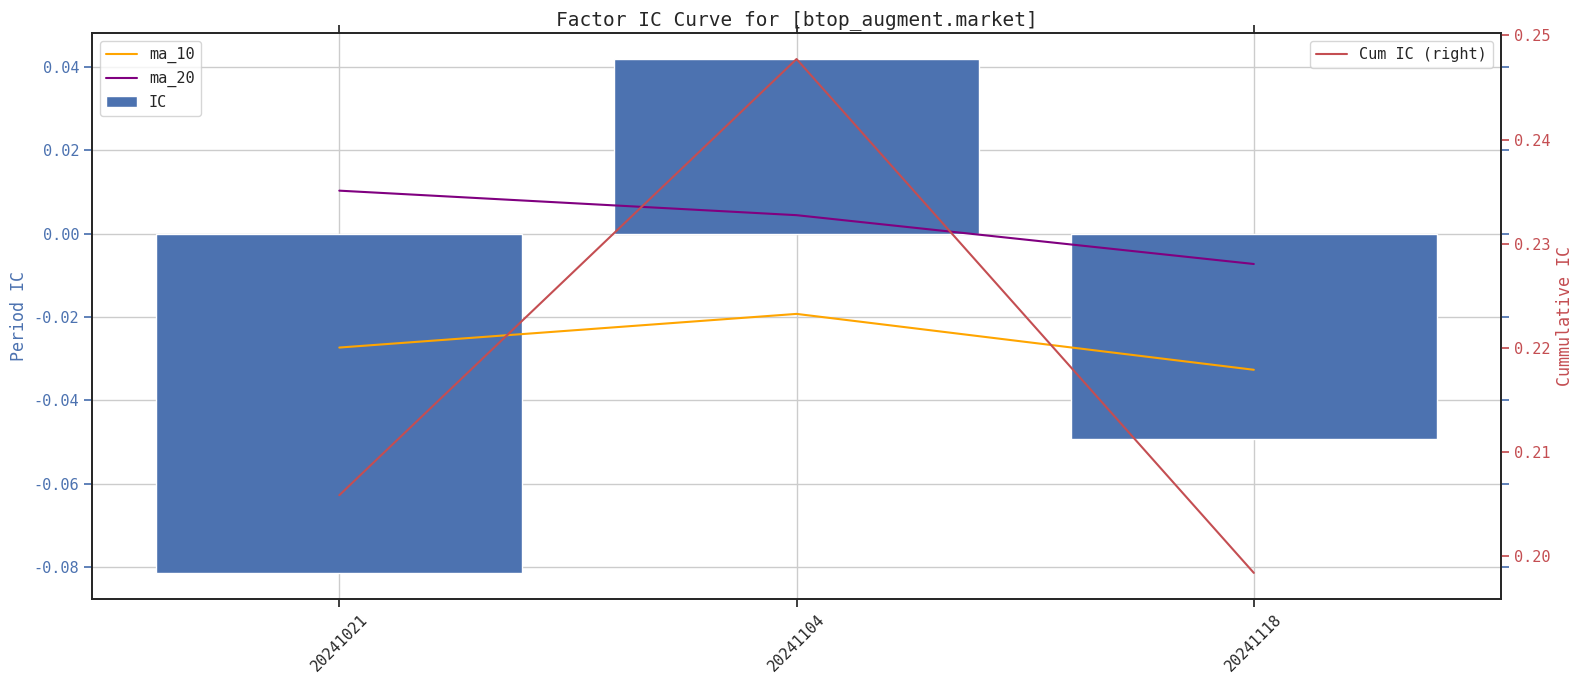

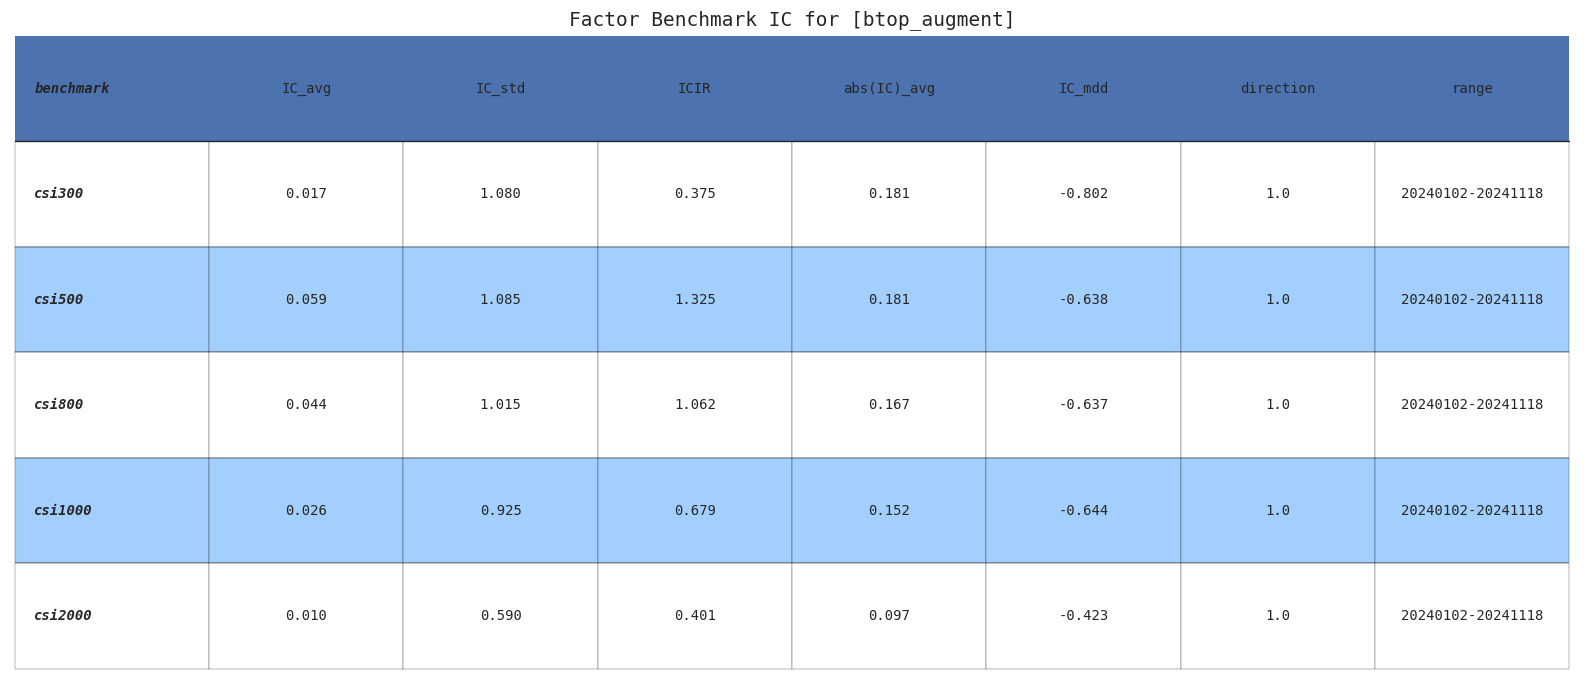

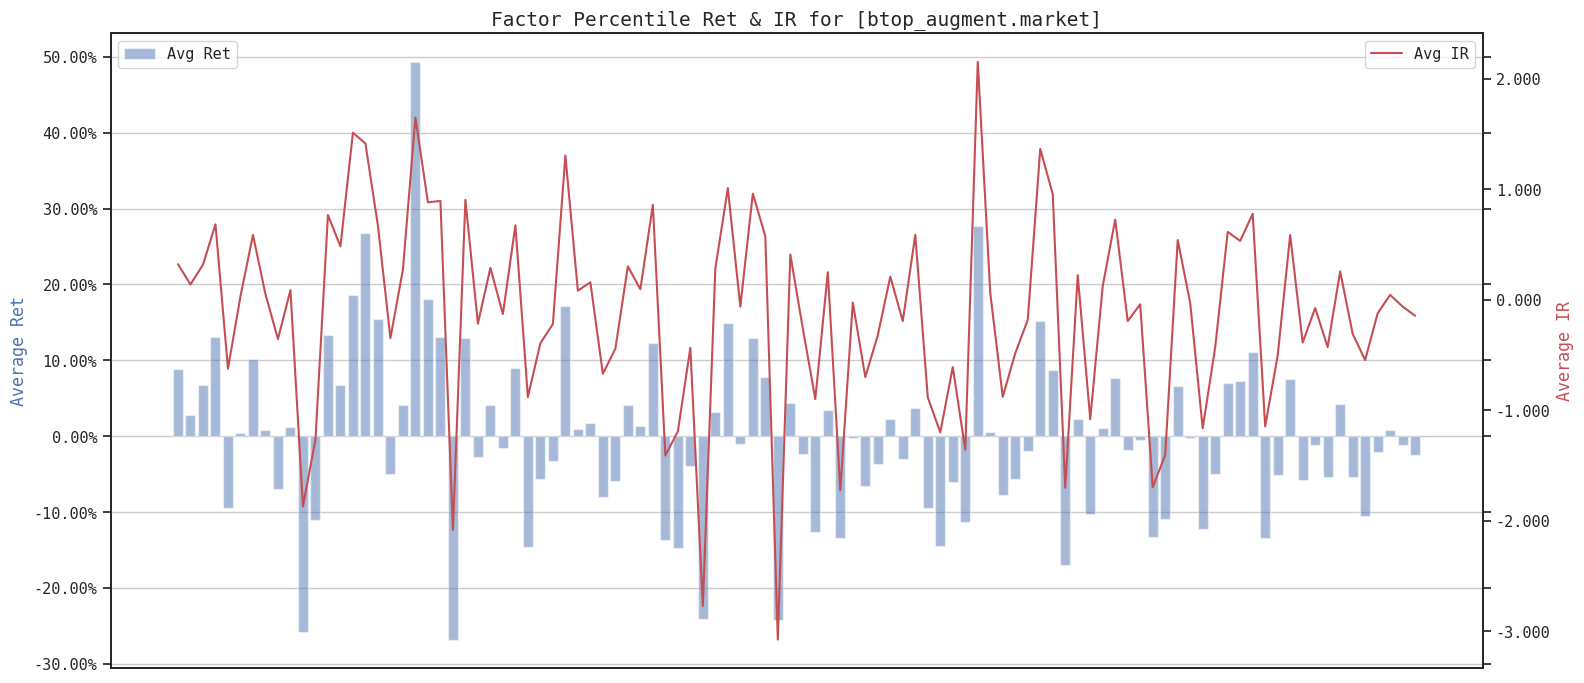

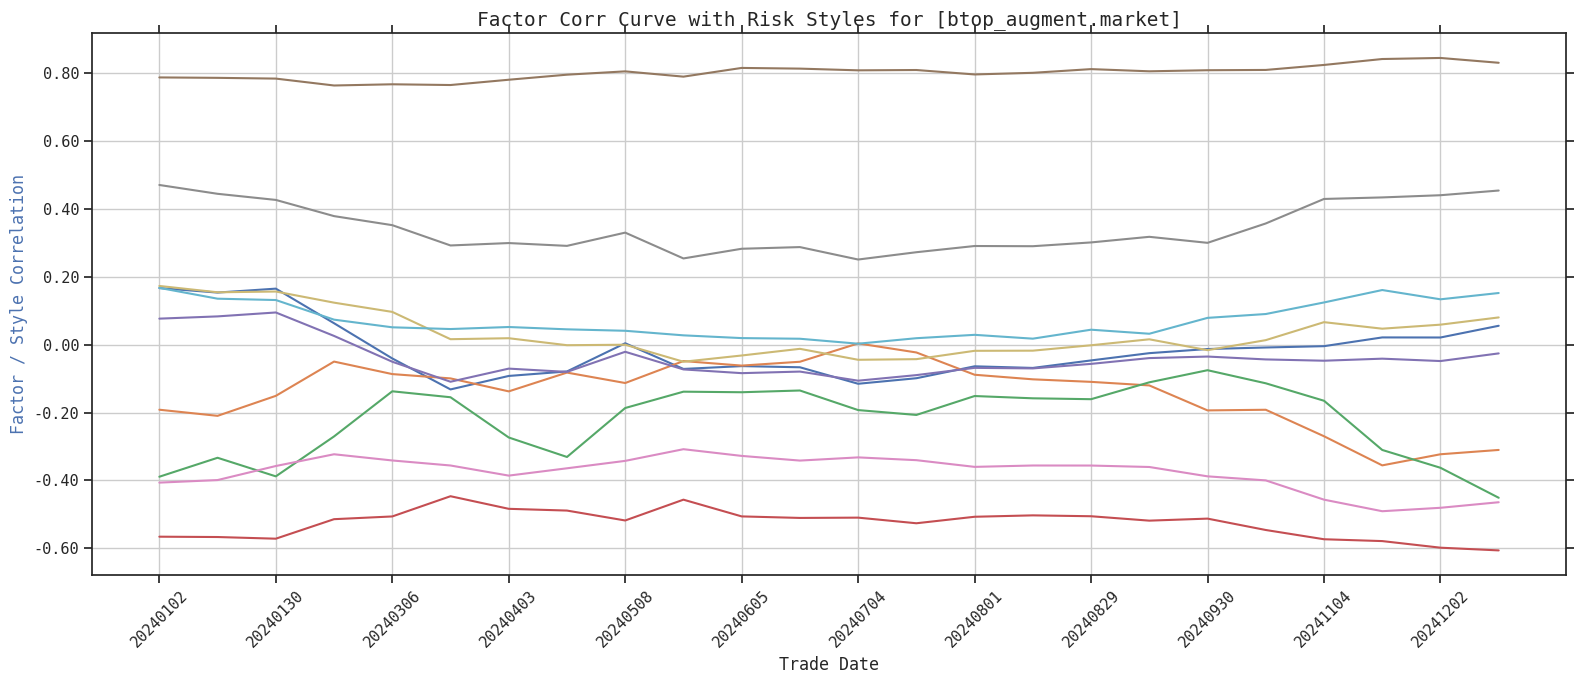

In [2]:
factor.fast_analyze()

In [11]:
from src import PATH
date = 20241203
PATH.factor_load('vol_high_std' , date , verbose = False)

,secid,vol_high_std
0,1,0.383663
1,2,0.429490
2,4,0.258678
3,6,0.322761
4,7,0.486756
...,...,...
5367,920088,NaN
5368,920099,NaN
5369,920111,NaN
5370,920118,NaN


In [21]:
from src_factor_definition.level1.fundamental.valuation_augment import btop
from src.data import DATAVENDOR

import pandas as pd

date = 20241203

bp_raw = btop.Eval(date)
fixed_asset_ratio  = DATAVENDOR.get_fin_latest('bs@fix_assets@qtr / ta@qtr' , date)
capital_intensity  = DATAVENDOR.get_fin_latest('ta@qtr / sales@qtr' , date)
liability_ratio    = DATAVENDOR.get_fin_latest('liab@qtr / ta@qtr' , date)
inventory_turnover = -DATAVENDOR.get_fin_latest('sales@qtr / bs@inventories@qtr' , date)

# score = lambda x : x.rank(pct = True)
heavy_asset = pd.concat([fixed_asset_ratio , capital_intensity , liability_ratio , inventory_turnover] , axis = 1)



In [23]:
heavy_asset.rank(pct = True , na_option='bottom').mean(axis = 1).rename('heavy_asset').rank(pct = True).reindex(bp_raw.index)

0            NaN
1       0.938271
2       0.868033
3       0.011113
4       0.156103
          ...   
5367         NaN
5368         NaN
5369         NaN
5370         NaN
5371         NaN
Name: heavy_asset, Length: 5372, dtype: float64

In [20]:
heavy_asset = heavy_asset.rank(pct = True , na_option='bottom').mean(axis = 1).rename('heavy_asset').rank(pct = True).reindex(bp_raw.index)
bp_range = (bp_raw < 1 / 0.8) & (heavy_asset >= 0.5)
bp_range.sum()

0            NaN
1       0.938271
2       0.868033
3       0.011113
4       0.156103
          ...   
5367         NaN
5368         NaN
5369         NaN
5370         NaN
5371         NaN
Name: heavy_asset, Length: 5372, dtype: float64

In [16]:
inventory_turnover

secid
1                  NaN
2            -0.133111
3        -11519.936379
4           -21.811605
5            -4.794137
              ...     
920099       -0.340220
920106             NaN
920111             NaN
920118       -4.629249
920128             NaN
Name: revenue / inventories, Length: 5757, dtype: float64

In [7]:
btop_augment.Calc(20241120).notna().sum()

755

In [5]:
from src_factor_definition.level1.fundamental.valuation_augment import btop_augment
a = btop_augment()

a.eval_factor(20241101)

1              NaN
2        -2.108291
4              NaN
6         0.082470
7              NaN
            ...   
920019         NaN
920066         NaN
920088         NaN
920099         NaN
920118         NaN
Name: btop_augment, Length: 5363, dtype: float64

In [4]:


hier.update()

Factor : ampl_slicecp1m at date 20241101 deploy successful
Factor : amt_cv12m at date 20241101 deploy successful
Factor : amt_cv1m at date 20241101 deploy successful
Factor : amt_cv2m at date 20241101 deploy successful
Factor : amt_cv3m at date 20241101 deploy successful
Factor : amt_cv6m at date 20241101 deploy successful
Factor : anndt_phigh at date 20241101 deploy successful
Factor : assetcur_asset at date 20241101 deploy successful
Factor : assetsturn_qtr at date 20241101 deploy successful
Factor : assetsturn_ttm at date 20241101 deploy successful
Factor : assetsturn_ttm_yoy at date 20241101 deploy successful
Factor : assetsturn_yoy at date 20241101 deploy successful
Factor : beta_12m at date 20241101 deploy successful
Factor : beta_1m at date 20241101 deploy successful
Factor : beta_2m at date 20241101 deploy successful
Factor : beta_3m at date 20241101 deploy successful
Factor : beta_6m at date 20241101 deploy successful
Factor : beta_slicevol1m at date 20241101 deploy successful

d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241101 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241101 deploy successful
Factor : etop_augment at date 20241101 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241101 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241104 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241104 deploy successful
Factor : etop_augment at date 20241104 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241104 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241105 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241105 deploy successful
Factor : etop_augment at date 20241105 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241105 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241106 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241106 deploy successful
Factor : etop_augment at date 20241106 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241106 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241107 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241107 deploy successful
Factor : etop_augment at date 20241107 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241107 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241108 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241108 deploy successful
Factor : etop_augment at date 20241108 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241108 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241111 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241111 deploy successful
Factor : etop_augment at date 20241111 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241111 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241112 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241112 deploy successful
Factor : etop_augment at date 20241112 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241112 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241113 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241113 deploy successful
Factor : etop_augment at date 20241113 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241113 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241114 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241114 deploy successful
Factor : etop_augment at date 20241114 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241114 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241115 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241115 deploy successful
Factor : etop_augment at date 20241115 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241115 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241118 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241118 deploy successful
Factor : etop_augment at date 20241118 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241118 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241119 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241119 deploy successful
Factor : etop_augment at date 20241119 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241119 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241120 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241120 deploy successful
Factor : etop_augment at date 20241120 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241120 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241121 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241121 deploy successful
Factor : etop_augment at date 20241121 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241121 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241122 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241122 deploy successful
Factor : etop_augment at date 20241122 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241122 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241125 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241125 deploy successful
Factor : etop_augment at date 20241125 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241125 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241126 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241126 deploy successful
Factor : etop_augment at date 20241126 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241126 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241127 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241127 deploy successful
Factor : etop_augment at date 20241127 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241127 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241128 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241128 deploy successful
Factor : etop_augment at date 20241128 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241128 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241129 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241129 deploy successful
Factor : etop_augment at date 20241129 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241129 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241202 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241202 deploy successful
Factor : etop_augment at date 20241202 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241202 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241203 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241203 deploy successful
Factor : etop_augment at date 20241203 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241203 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241204 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241204 deploy successful
Factor : etop_augment at date 20241204 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241204 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241205 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241205 deploy successful
Factor : etop_augment at date 20241205 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241205 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241206 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241206 deploy successful
Factor : etop_augment at date 20241206 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241206 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241209 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241209 deploy successful
Factor : etop_augment at date 20241209 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241209 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241210 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241210 deploy successful
Factor : etop_augment at date 20241210 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241210 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241211 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241211 deploy successful
Factor : etop_augment at date 20241211 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241211 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241212 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241212 deploy successful
Factor : etop_augment at date 20241212 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241212 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241213 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241213 deploy successful
Factor : etop_augment at date 20241213 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : valuation_augment at date 20241213 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

Factor : btop_augment update at date 20241216 failed: factor_value must have at least 100 finite values , but got 0
Factor : cfev_augment at date 20241216 deploy successful
Factor : etop_augment at date 20241216 deploy successful
Factor : valuation_augment at date 20241216 deploy successful


d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  np.nanmean(v)
d:\Coding\learndl\learndl\src\func\transform.py:184: RuntimeWarning: All-NaN slice encountered
  s = np.nanmedian(np.abs(v - np.nanmedian(v))) if scale == 'mad' else np.nanstd(v)
d:\Coding\learndl\learndl\src\func\transform.py:185: RuntimeWarning: All-NaN slice encountered
  c = np.nanmedian(v) if center == 'median' else  

In [7]:
hier.update_jobs(file_name = 'liquidity_illiq')
df = hier.jobs()


array([illiq_12m(from20070101,behavior,liquidity)[0dates],
       illiq_1m(from20070101,behavior,liquidity)[0dates],
       illiq_2m(from20070101,behavior,liquidity)[0dates],
       illiq_3m(from20070101,behavior,liquidity)[0dates],
       illiq_6m(from20070101,behavior,liquidity)[0dates]], dtype=object)

In [5]:
df = hier.jobs()
df['factor'].unique()


array([illiq_12m(from20070101,behavior,liquidity)[0dates],
       illiq_1m(from20070101,behavior,liquidity)[0dates],
       illiq_2m(from20070101,behavior,liquidity)[0dates],
       illiq_3m(from20070101,behavior,liquidity)[0dates],
       illiq_6m(from20070101,behavior,liquidity)[0dates]], dtype=object)

In [6]:
hier.update()

Factor : illiq_12m at date 20070104 deploy successful
Factor : illiq_1m at date 20070104 deploy successful
Factor : illiq_2m at date 20070104 deploy successful
Factor : illiq_3m at date 20070104 deploy successful
Factor : illiq_6m at date 20070104 deploy successful
Factor : illiq_12m at date 20070105 deploy successful
Factor : illiq_1m at date 20070105 deploy successful
Factor : illiq_2m at date 20070105 deploy successful
Factor : illiq_3m at date 20070105 deploy successful
Factor : illiq_6m at date 20070105 deploy successful
Factor : illiq_12m at date 20070108 deploy successful
Factor : illiq_1m at date 20070108 deploy successful
Factor : illiq_2m at date 20070108 deploy successful
Factor : illiq_3m at date 20070108 deploy successful
Factor : illiq_6m at date 20070108 deploy successful
Factor : illiq_12m at date 20070109 deploy successful
Factor : illiq_1m at date 20070109 deploy successful
Factor : illiq_2m at date 20070109 deploy successful
Factor : illiq_3m at date 20070109 deploy 